# Vectorización en Python: Proyección 3D en una malla 2D
- Profesor: Pablo Román
- Alumno: Nícolas Farfán Cheneaux

### Introducción
En el ámbito de la computación científica y la ciencia de datos, una de las tareas fundamentales es la manipulación eficiente de grandes conjuntos de datos. Uno de los desafíos específicos en este dominio es la proyección de mediciones tridimensionales (3D) en una malla bidimensional (2D). Esta tarea se encuentra frecuentemente en la visualización de datos, donde las representaciones en 2D son esenciales para la interpretación y análisis de fenómenos que ocurren en un espacio tridimensional.

El presente trabajo se enfoca en el desarrollo de un algoritmo de gridding vectorizado que permite proyectar y estimar valores medidos en una malla 2D a partir de mediciones dispersas en 3D. Este algoritmo es crucial en múltiples aplicaciones, desde el procesamiento de imágenes hasta el modelado geoespacial, donde la precisión y la eficiencia de la computación no son solo deseables, sino necesarias.

### Objetivos
El objetivo principal de este trabajo es construir un programa en Python que aproveche la vectorización para realizar la proyección de datos 3D a una malla 2D de manera eficiente, alcanzando velocidades de ejecución comparables a un programa compilado en C y posiblemente incluyendo aceleración vía GPU. Esto se logra, tradicionalmente, al costo de un mayor uso de memoria. Al evitar el uso de bucles de Python y emplear operaciones vectorizadas, se busca mejorar sustancialmente el rendimiento de cálculos intensivos.

Específicamente, se pretende:

Implementar la proyección de un conjunto de mediciones dispersas 3D en un plano 2D sin la utilización de bucles.
Desarrollar la operación de gridding que asigne a cada píxel de la malla un valor promedio ponderado de las mediciones vecinas, dentro de un radio definido.
Comparar el rendimiento de la implementación vectorizada con una versión que utilice bucles, tanto en NumPy como en CuPy, para evaluar las mejoras en velocidad y uso de recursos.
Documentar y analizar los resultados obtenidos, ofreciendo una interpretación clara de los datos y del rendimiento del algoritmo.
Con estos objetivos en mente, el trabajo a continuación presenta un enfoque detallado de la implementación, los experimentos realizados para validar la solución, y una discusión de los resultados y posibles mejoras.

### Desarrollo

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

#### Definición del plano 3D aleatorio
Se definen 10.000 puntos o vectores tridimensionales (x,y,z) que tendrán asociado una medición.
El tamaño de la grilla será de 256x256, y los casilleros estarán separados por un delta.

In [2]:
N = 10000 # numero de mediciones
n = 256 # tamaño de grilla
L = 1
low = -1 # Puntos entre -1 y 1
high = 1
delta = (high-low) / n
r = 2 * delta

X = np.random.uniform(low = low, high = high, size = (3 * N)) # Genera un arreglo tridimensional de 1000 coordenadas con su respectivo valor (x,y,z)
X = np.reshape(X, (N, 3)) # 10000 filas de mediciones y 3 columnas de coordenadas 3D entre -1 y 1, cada vector de 3 dim
w = 1 + np.random.uniform(low = -0.1, high = 0.1, size = (N)) # pesos de las mediciones *un vector de 1000 elementos random para los pesos
X.shape

(10000, 3)

Notar que se tiene 10.000 filas y 3 columnas al tratarse de 10.000 puntos ubicados en un plano 3D (x, y, z)

#### Generación de las mediciones 3D
Usando la función mockImage a partir de 2 coordenadas obtiene una medición para cada punto.

In [3]:
def mockImage(u,v): ## dado un par de coordenadas genero una medicion!
  rr = u**2 + v**2
  v = (np.sin(rr/0.001/np.pi))*np.exp(-rr*rr/0.006)/2.0
  v[v<0.]=0.0
  return v

#### Gráfico 3D

Dada la función mockImage (plano 2d), se mantiene la dimensión z constante obteniendo una forma de cilindro.

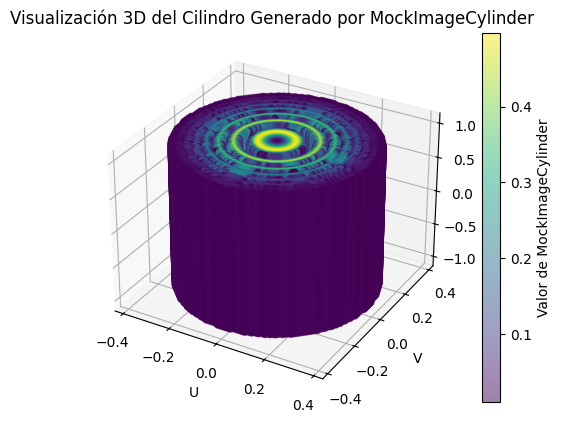

In [4]:
# Rango para u, v, y w
u = np.linspace(-L, L, n)
v = np.linspace(-L, L, n)
z = np.linspace(-L, L, n)

# Crear malla 3D
U, V, W = np.meshgrid(u, v, z, indexing='ij')

# Calcular los valores usando mockImageCylinder
Values = mockImage(U, V)
Values.shape

# Configurar la figura y el eje para 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Aplanar los arrays para graficar
x = U.flatten()
y = V.flatten()
z = W.flatten()
values = Values.flatten()

# Usar un filtro para reducir el número de puntos (opcional)
mask = values > 0.01  # Solo mostrar puntos con valores significativos

# Crear un gráfico de dispersión 3D
sc = ax.scatter(x[mask], y[mask], z[mask], c=values[mask], cmap='viridis', alpha=0.5)

# Añadir una barra de color para interpretar los valores
cbar = fig.colorbar(sc)
cbar.set_label('Valor de MockImageCylinder')

# Etiquetas y título
ax.set_xlabel('U')
ax.set_ylabel('V')
ax.set_zlabel('W')
ax.set_title('Visualización 3D del Cilindro Generado por MockImageCylinder')

plt.show()

#### Parametrización de la orientación de dicho plano

In [5]:
alfa = np.pi / 4  # 45 grados
beta = np.pi / 4  # 45 grados

### 2. Proyección 3D a 2D sin usar Loops

Dados los valores de alfa y beta y las posiciones de los vectores se obtiene un proyección al plano 2d, obteniendo X, Y.

In [6]:
def proy2d(alfa, beta, X):
    # Definir los vectores unitarios basados en alpha y beta
    x_hat = np.array([np.cos(alfa) * np.cos(beta), np.sin(alfa) * np.cos(beta), -np.sin(beta)])
    y_hat = np.array([-np.sin(alfa), np.cos(alfa), 0])
    
    # Calcular las proyecciones 2D
    x_projections = np.dot(X, x_hat)  # Producto punto para las proyecciones x, y
    y_projections = np.dot(X, y_hat)  # Producto punto para las proyecciones x, y

    return x_projections, y_projections

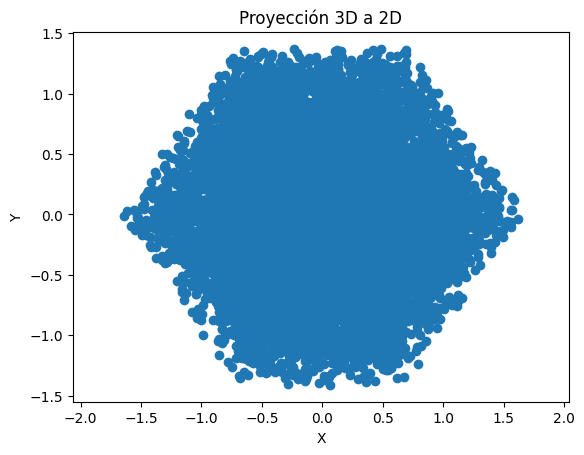

In [7]:
x_projections, y_projections = proy2d(alfa, beta, X)
plt.scatter(x_projections, y_projections)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Proyección 3D a 2D')
plt.axis('equal')
plt.show()

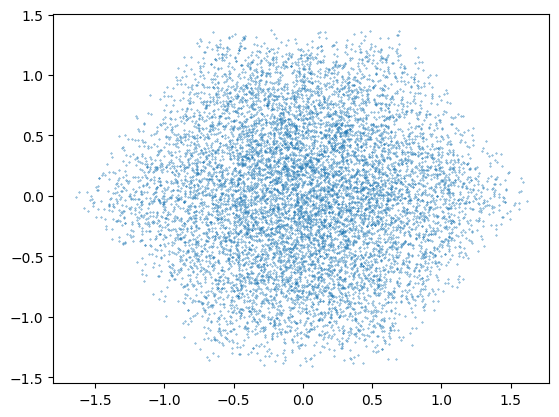

In [8]:
plt.scatter(x_projections, y_projections, s=0.1)

#### Resultados de la proyección
Como se puede observa dado distintos alfa o beta se puede obtener distinas formas o contornos de bidimensionales de la imagen 3D dado que la orientación afecta como se ve la proyección en 2D, para terminos de este laboratorio al tratarse de un cilindro se decide ir por un ángulo de 45°.

### 3. Gridding sobre la proyección 2D (numpy, cupy, loops)
Usando la función mockImage se definen 10000 valores $V_k$.

Ya hecha la proyección se procede a redimensionar a la dimensión de las mediciones para operarlo con Broadcasting, dados los valores de:
- V: Medición de cada pixel
- w: Peso de cada pixel
- x: Coordenadas X de cada pixel
- y: Coordenadas Y de cada pixel
(El sufijo r se refiere a reshape en caso aplique)

In [31]:
V = mockImage(x_projections, y_projections)
Vr = np.reshape(V, (1, 1, N))
wr = np.reshape(w, (1, 1, N))
x = np.reshape(x_projections, (1, 1, N))
y = np.reshape(y_projections, (1, 1, N))
dx = 2 * L / n # ancho del pixel porque va entre -1 y 1 para las coordenadas

#### Función gridding (numpy)
Recibe como parámetro las proyecciones en X, Y, mediciones, pesos, radio y dimensión grilla.

In [9]:
def gridding_numpy(x, y, med, w, dx, n):
    r = dx * 2
    
    X = np.linspace(-L,L,n) # definición de la grilla
    Y = np.linspace(-L,L,n)

    X = np.reshape(X, (n,1,1)) # redimensión de la grilla
    Y = np.reshape(Y, (1,n,1))

    Sw = np.zeros(shape=(n,n)) # suma de las mediciones ponderadas en la grilla
    S = np.zeros(shape=(n,n)) # suma de los pesos
    B = (X-x)**2 + (Y-y)**2 <= r**2
    # genera un arreglo de (1,1,N)
    K = med*w # dimension (1,1,N)
    
    A1 = K * B
    A2 = w * B
    Sw = np.sum(A1, axis=2) # equivalente a sumar en la dimension de datos
    S = np.sum(A2, axis=2)
    VG = np.zeros_like(S, dtype=float)
    np.divide(Sw, S, out=VG, where=(S != 0))
    return VG

In [10]:
%%time
grid = gridding_numpy(x, y, Vr, wr, dx, n)

CPU times: total: 5.64 s
Wall time: 15.8 s


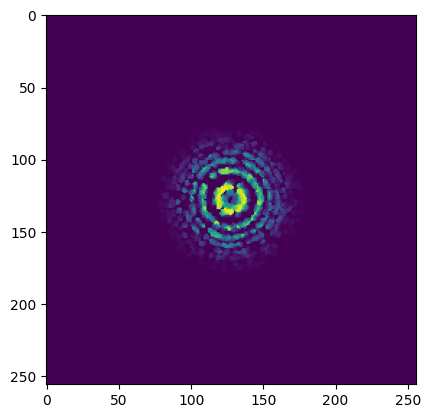

In [11]:
plt.imshow(grid)

#### Función gridding (cupy)

In [44]:
def gridding_cupy(x, y, med, w, dx, n):
    r = dx * 2
    
    X = cp.linspace(-L,L,n) # definición de la grilla
    Y = cp.linspace(-L,L,n)

    X = cp.reshape(X, (n,1,1)) # redimensión de la grilla
    Y = cp.reshape(Y, (1,n,1))

    Sw = cp.zeros(shape=(n,n)) # suma de las mediciones ponderadas en la grilla
    S = cp.zeros(shape=(n,n)) # suma de los pesos
    B = (X-x)**2 + (Y-y)**2 <= r**2
    # genera un arreglo de (1,1,N)
    K = med*w # dimension (1,1,N)
    
    A1 = K * B
    A2 = w * B
    Sw = cp.sum(A1, axis=2) # equivalente a sumar en la dimension de datos
    S = cp.sum(A2, axis=2)
    VG = Sw/S
    VG[S == 0] = 0 # eliminacion de NAN
    return VG

In [35]:
xc = cp.asarray(x)
yc = cp.asarray(y)
Vc = cp.asarray(Vr)
wc = cp.asarray(wr)

In [48]:
cp.get_default_pinned_memory_pool().free_all_blocks()
cp.get_default_memory_pool().free_all_blocks()

In [49]:
%%time
grid = gridding_cupy(xc, yc, Vc, wc, dx, n)

CPU times: total: 1.14 s
Wall time: 2.84 s


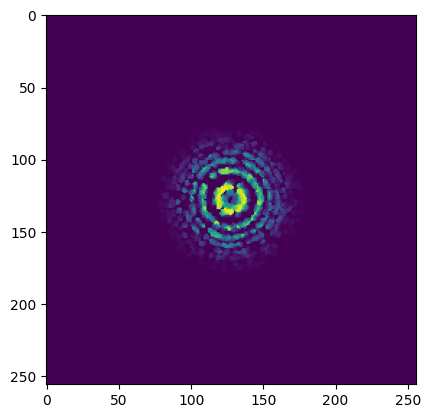

In [50]:
plt.imshow(cp.asnumpy(grid))

#### Función gridding (loops)

In [52]:
def slow_gridding(x, y, V, w, dx, n):
    X = np.linspace(-L, L, n)  # Definición de la grilla
    Y = np.linspace(-L, L, n)
    r = dx * 2
    
    Sw = np.zeros((n, n))  # Suma ponderada de los valores
    S = np.zeros((n, n))  # Suma ponderada de los pesos
    
    for i in range(n):
        for j in range(n):
            for k in range(len(V)):  # Iterando sobre la longitud de V
                # Comprobando si el punto (x[k], y[k]) está dentro del círculo de radio r alrededor del punto de la grilla (X[i], Y[j])
                if ((X[i] - x[k]) ** 2 + (Y[j] - y[k]) ** 2 <= r ** 2):
                    Sw[j, i] += V[k] * w[k]  # Acumulando el valor ponderado
                    S[j, i] += w[k]          # Acumulando los pesos
    
    # Evitar la división por cero utilizando np.where
    VG = np.where(S != 0, Sw / S, 0)  # Calculando el valor promedio ponderado
    return VG

In [53]:
%%time
grid = slow_gridding(x_projections, y_projections, V, w, dx, n)

CPU times: total: 5min 22s
Wall time: 8min 38s


C:\Users\n1c8l\AppData\Local\Temp\ipykernel_8036\2834669941.py:18: RuntimeWarning: invalid value encountered in divide
  VG = np.where(S != 0, Sw / S, 0)  # Calculando el valor promedio ponderado


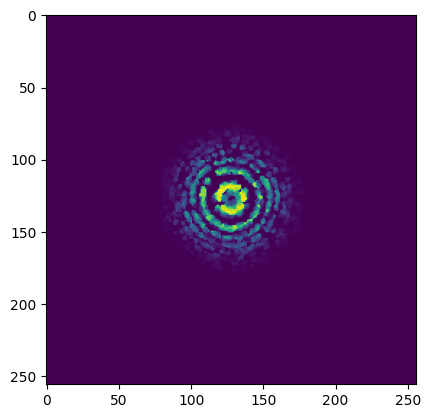

In [54]:
plt.imshow(grid)

#### Comparativa GPU vs CPU

| CPU  | GPU | Loops |
| ------------- | ------------- | ------------- |
| 15.8s  | 2.84s  | 8min38s |

Como se puede observar la versión sin numpy/cupy usando loops, tarda demasiado tiempo.
En cuanto a la diferencia entre GPU y CPU, usando CUDA que utiliza el software gráfico que tiene un mejor tiempo de respuesta que la CPU al poder paralelizarse y utilizar tecnología para calculos rápidos e instantáneos.

#### Resultados finales obtenidos
Como se puede ver independiente de la librería usando GPU/CPU se logra obtener el resultado correcto de griding, a pesar que es mejorable en muchos aspectos, sin embargo el propósito de este notebook era entender el funcionamiento del broadcast y como puede ser aprovechado para distintas operaciones con arreglos, es por esto que se detalla paso por paso como está operando numpy/cupy en cada operación de broadcasting.